<a href="https://colab.research.google.com/github/theofanisko/MasterThesis/blob/main/LSTM_model_analysis_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Intro Data

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Total.xlsx to Total.xlsx


In [3]:
import io
stock=pd.read_excel(io.BytesIO(uploaded['Total.xlsx']))
stock

,Date,THRr,HRMr,EYDr,EEEr,AUTr,ASCr,ALMr,ACBr,MYTr,FRLr
0,"Aug 06, 2015",1.40,1.67,6.29,19.9155,8.32,0.32,0.285,3.950,5.18,2.65
1,"Aug 07, 2015",1.34,1.63,6.15,20.7159,8.30,0.31,0.270,6.550,5.15,2.50
2,"Aug 10, 2015",1.39,1.64,5.83,19.7743,8.41,0.31,0.280,6.600,5.37,2.48
3,"Aug 11, 2015",1.44,1.63,5.76,19.5483,8.27,0.31,0.280,7.250,5.39,2.51
4,"Aug 12, 2015",1.30,1.55,5.88,19.0022,8.25,0.31,0.280,6.650,5.31,2.56
...,...,...,...,...,...,...,...,...,...,...,...
1469,"Jul 08, 2021",7.00,9.15,7.91,30.7500,6.98,2.25,1.980,0.994,15.21,4.36
1470,"Jul 09, 2021",6.89,9.16,7.88,30.1900,6.79,2.18,1.870,0.990,14.84,4.37
1471,"Jul 12, 2021",6.99,9.41,8.09,30.0600,6.95,2.25,1.855,1.140,15.11,4.26
1472,"Jul 13, 2021",6.86,9.36,7.83,30.0000,6.90,2.22,1.980,1.100,14.62,4.27


In [4]:
stock.describe()

,THRr,HRMr,EYDr,EEEr,AUTr,ASCr,ALMr,ACBr,MYTr,FRLr
count,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000
mean,2.339204,4.688005,6.126771,24.383282,7.459830,1.651926,0.597783,1.731373,8.061472,4.471018
std,1.003729,2.281259,1.043338,4.578815,2.930922,0.937234,0.456567,1.126933,2.832323,1.052621
min,1.200000,1.090000,3.690000,15.489900,3.200000,0.250000,0.134000,0.420000,2.840000,1.980000
25%,1.770000,2.270000,5.390000,20.153275,5.592500,0.661250,0.252000,1.160000,6.182500,3.792500
50%,2.140000,4.920000,5.900000,25.200000,6.120000,1.930000,0.389000,1.670000,8.390000,4.430000
75%,2.560000,6.190000,6.817500,27.897500,10.000000,2.400000,0.839500,1.900750,9.677500,5.437500
max,7.000000,10.500000,9.200000,34.630000,17.000000,3.240000,2.130000,8.400000,15.990000,6.200000


In [5]:

stock.isnull().sum()

Date    0
THRr    0
HRMr    0
EYDr    0
EEEr    0
AUTr    0
ASCr    0
ALMr    0
ACBr    0
MYTr    0
FRLr    0
dtype: int64

In [7]:

close_price=stock["AUTr"]
close_price.index = stock["Date"]
close_price.head()


Date
Aug 06, 2015    8.32
Aug 07, 2015    8.30
Aug 10, 2015    8.41
Aug 11, 2015    8.27
Aug 12, 2015    8.25
Name: AUTr, dtype: float64

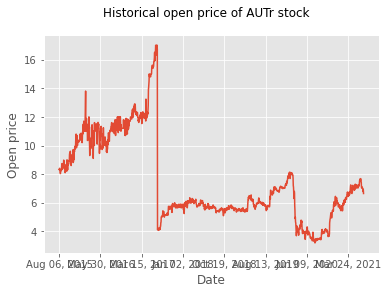

In [8]:
import matplotlib.pyplot as plt
plt.style.use ('ggplot')
close_price.plot(subplots=True, title='Historical open price of AUTr stock',ylabel='Open price')
plt.savefig('Historical Open price of FRLr the stock.png')

#Multi step model

In [9]:
import tensorflow as tf
from keras import optimizers

import sys
assert sys.version_info >= (3,5)

import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd


# min-maxScaler
from sklearn.preprocessing import MinMaxScaler

# plot
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from math import sqrt

# Transform Data

In [12]:
close_price = stock.AUTr.values
close_price = np.reshape(close_price,(-1,1))

scaler = MinMaxScaler()
data_normalised = scaler.fit_transform(close_price)


#Split Data (Train 80% - Validate 10% - Test 10%)

In [13]:
train_size = int(len(data_normalised) * 0.80)
half_rest = int((len(data_normalised) - train_size)/2)

train_set = data_normalised[0:train_size,:]
val_set = data_normalised[train_size:train_size+half_rest,:]
test_set = data_normalised[train_size+half_rest:len(data_normalised),:]

#Creating sliding windows

In [15]:
def createWindows(dataset, window):
    X_train = []
    Y_train = []
    
    for i in range(len(dataset)-window-1):
        X_train.append(dataset[i:(i+window),0])
        Y_train.append(dataset[i+window,0])
    return np.array(X_train),np.array(Y_train)

In [16]:
X_train, Y_train = createWindows(train_set,20)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

In [17]:

X_val, Y_val = createWindows(val_set,20)
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [18]:
X_test, Y_test = createWindows(test_set,20)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

#Combination of X_train and Y_train to tensors and shuffle them, while choosing the batch size

In [19]:
BATCH_SIZE = 60
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [20]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

#Building the Model

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(200, return_sequences=True, input_shape= X_train.shape[-2:]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Activation('sigmoid'),
    tf.keras.layers.Dense(1)
    ])


model.compile(loss="mse", optimizer=opt)

In [22]:
import keras.backend as K
print(K.eval(model.optimizer.lr))

0.001


# Model Summary and the model's tree scrature

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 200)            176800    
                                                                 
 dropout (Dropout)           (None, 1, 200)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               120400    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 297,301
Trainable params: 297,301
Non-trai

In [24]:
#tf.keras.utils.plot_model(model)

In [25]:
lstm = model.fit(train_univariate, epochs=7,steps_per_epoch=200,validation_data=val_univariate,validation_steps=50)

Epoch 1/7
200/200 [==============================] - 8s 12ms/step - loss: 0.0086 - val_loss: 9.2569e-04
Epoch 2/7
200/200 [==============================] - 2s 8ms/step - loss: 0.0025 - val_loss: 4.7071e-04
Epoch 3/7
200/200 [==============================] - 2s 8ms/step - loss: 0.0022 - val_loss: 5.3563e-04
Epoch 4/7
200/200 [==============================] - 2s 8ms/step - loss: 0.0020 - val_loss: 7.6134e-04
Epoch 5/7
200/200 [==============================] - 2s 8ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 6/7
200/200 [==============================] - 2s 8ms/step - loss: 0.0018 - val_loss: 8.1322e-04
Epoch 7/7
200/200 [==============================] - 2s 8ms/step - loss: 0.0016 - val_loss: 0.0013


In [26]:
def plot(timeseries, real, prediction):
    plt.plot(timeseries.flatten(), ".-")
    time_steps = timeseries[0].shape[0]
    if real is not None:
        plt.plot(time_steps, real,"bx", markersize=10)
    if prediction is not None:
        plt.plot (time_steps, prediction,'go')
    return plt

#Model evaluate on validation set

In [28]:
y_true_val= Y_val
y_true_val= scaler.inverse_transform(y_true_val.reshape(-1, 1)).reshape(-1 ,)

In [29]:
y_pred_val = model.predict(X_val).reshape(-1, )
y_pred_val = scaler.inverse_transform(y_pred_val.reshape(-1, 1)).reshape(-1 ,)

In [30]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true_val, y_pred_val)

0.46372871414063477

In [31]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true_val, y_pred_val)

0.24772842644928372

In [32]:
# root mean square error
rms = sqrt(mean_squared_error(y_true_val, y_pred_val))
rms

0.4977232428260546

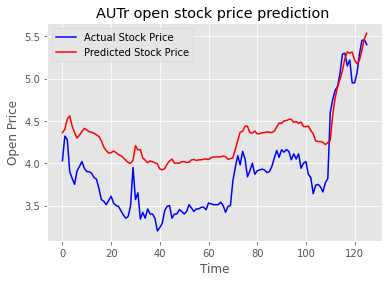

In [33]:
plt.plot(y_true_val, color = 'blue', label = 'Actual Stock Price')
plt.plot(y_pred_val, color = 'red', label = 'Predicted Stock Price')
plt.title('AUTr open stock price prediction ')
plt.xlabel('Time')
plt.ylabel('Open Price')
plt.legend()
plt.show()

#Model evaluate on the test set

In [34]:
y_true_test = Y_test
y_true_test = scaler.inverse_transform(Y_test.reshape(-1, 1)).reshape(-1 ,)
y_pred_test = model.predict(X_test).reshape(-1, )
y_pred_test = scaler.inverse_transform(y_pred_test.reshape(-1, 1)).reshape(-1 ,)

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true_test, y_pred_test)

0.10938089265598089

In [35]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true_test, y_pred_test)

0.01937359952485644

In [36]:
# root mean square error
rms = sqrt(mean_squared_error(y_true_test, y_pred_test))
rms


0.13918907832461727

In [38]:

TK= np.mean((np.absolute(y_true_test-y_pred_test)/y_true_test)*100)
TK

1.680926974689241

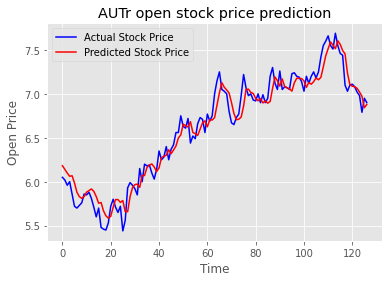

In [39]:

plt.plot(y_true_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(y_pred_test, color = 'red', label = 'Predicted Stock Price')
plt.title('AUTr open stock price prediction')
plt.xlabel('Time')
plt.ylabel('Open Price')
plt.legend()
plt.show()